In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

from collections import deque
import heapq

import tqdm

import keras as keras
import keras.layers as layers

2024-12-03 02:09:01.196404: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 02:09:01.216593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def generate_map(x_size, y_size, th, start_x, start_y, end_x, end_y):
  map = np.random.rand(x_size, y_size)
  map[map < th] = 0
  map[map >= th] = 1
  map[start_x, start_y] = -1
  map[end_x, end_y] = -1

  return map

def generate_path(map, function, start_x, start_y, end_x, end_y):
  return [(start_x, start_y)] + function(map, start_x, start_y, end_x, end_y)

def generate_path_2d(map, function, start_x, start_y, end_x, end_y):
  path = generate_path(map, function, start_x, start_y, end_x, end_y)
  
  path_2d = np.zeros_like(map)
  for x, y in path:
    path_2d[x, y] = 1

  return path_2d

def generate_map_path(map, function, start_x, start_y, end_x, end_y):
  map_copy = map.copy()
  path = generate_path(map, function, start_x, start_y, end_x, end_y)

  for x, y in path:
    map_copy[x, y] = -1

  return map_copy

def plot_map(map):
  cmap = ListedColormap(['green', '#440154', '#FFED23'])
  plt.matshow(map, cmap = cmap)
  plt.show()

In [3]:
def get_neighbors(map, x, y):
    neighbors = []
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < map.shape[0] and 0 <= ny < map.shape[1] and map[nx][ny] != 1:
            neighbors.append((nx, ny))
    return neighbors

In [4]:
def a_star(map, start_x, start_y, end_x, end_y):
    start = (start_x, start_y)
    end = (end_x, end_y)

    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])  # Manhattan distance

    open_list = []
    heapq.heappush(open_list, (0, start))
    g_costs = {start: 0}
    parent = {start: None}

    while open_list:
        _, current = heapq.heappop(open_list)
        if current == end:
            break
        for neighbor in get_neighbors(map, *current):
            tentative_g_cost = g_costs[current] + 1
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                f_cost = tentative_g_cost + heuristic(neighbor, end)
                heapq.heappush(open_list, (f_cost, neighbor))
                parent[neighbor] = current

    # Reconstruct the path
    path = []
    node = end
    while node != start:
        path.append(node)
        node = parent[node]
    path.reverse()
    return path

In [5]:
data_x = []
data_y = []

for i in tqdm.tqdm_notebook(range(100000), desc = "a_star"):
    start_x = 0
    start_y = 0
    end_x = 0
    end_y = 0

    while((start_x - end_y)**2 + (start_y - end_y)**2 <= 15*15):
        start_x = int(np.random.rand() * 15)
        start_y = int(np.random.rand() * 15)
        end_x = int(np.random.rand() * 15)
        end_y = int(np.random.rand() * 15)

    try:
        map = generate_map(16, 16, 0.9, start_x, start_y, end_x, end_y)
        path = generate_path_2d(map, a_star, start_x, start_y, end_x, end_y)

        data_x.append(map)
        data_y.append(path)
    except:
        i -= 1

data_x = np.array(data_x)
data_y = np.array(data_y)

/tmp/ipykernel_30317/3578737814.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(100000), desc = "a_star"):


a_star:   0%|          | 0/100000 [00:00<?, ?it/s]

In [6]:
input_shape = [data_x.shape[1], data_x.shape[2], 1]
input_shape

[16, 16, 1]

In [7]:

from keras.models import Model
from keras.optimizers.schedules import CosineDecayRestarts
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Cropping2D

# Input layer
inputs = Input(shape = input_shape)
mod = 1

# Encoder: Downsampling with skip connections
conv1 = Conv2D(16 * mod, (3, 3), padding="same")(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Activation("relu")(conv1)
conv1 = Conv2D(16 * mod, (3, 3), padding="same")(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation("relu")(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # Downsample

conv2 = Conv2D(32 * mod, (3, 3), padding="same")(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation("relu")(conv2)
conv2 = Conv2D(32 * mod, (3, 3), padding="same")(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation("relu")(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # Downsample

conv3 = Conv2D(64 * mod, (3, 3), padding="same")(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation("relu")(conv3)
conv3 = Conv2D(64 * mod, (3, 3), padding="same")(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation("relu")(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  # Downsample

conv4 = Conv2D(128 * mod, (3, 3), padding="same")(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Activation("relu")(conv4)
conv4 = Conv2D(128 * mod, (3, 3), padding="same")(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Activation("relu")(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)  # Downsample

#-------------------------------------------------------------------

# Bottleneck: Reduced filters to represent the "bottleneck"
bottleneck = Conv2D(16 * mod, (3, 3), padding="same")(pool4)
bottleneck = BatchNormalization()(bottleneck)
bottleneck = Activation("relu")(bottleneck)

#-------------------------------------------------------------------

# Decoder: Upsampling with skip connections
up4 = UpSampling2D(size=(2, 2))(bottleneck)
up4 = Conv2D(128 * mod, (3, 3), padding="same")(up4)
up4 = BatchNormalization()(up4)
up4 = Activation("relu")(up4)

# Cropping to match spatial dimensions before concatenation
crop4 = Cropping2D(((0, 0), (0, 0)))(conv4)
up4 = Concatenate()([up4, crop4])  # Skip connection from cropped conv3
up4 = Conv2D(128 * mod, (3, 3), padding="same")(up4)
up4 = BatchNormalization()(up4)
up4 = Activation("relu")(up4)

up3 = UpSampling2D(size=(2, 2))(up4)
up3 = Conv2D(64 * mod, (3, 3), padding="same")(up3)
up3 = BatchNormalization()(up3)
up3 = Activation("relu")(up3)

# Cropping to match spatial dimensions before concatenation
crop3 = Cropping2D(((0, 0), (0, 0)))(conv3)
up3 = Concatenate()([up3, crop3])  # Skip connection from cropped conv3
up3 = Conv2D(64 * mod, (3, 3), padding="same")(up3)
up3 = BatchNormalization()(up3)
up3 = Activation("relu")(up3)

up2 = UpSampling2D(size=(2, 2))(up3)
up2 = Conv2D(32 * mod, (3, 3), padding="same")(up2)
up2 = BatchNormalization()(up2)
up2 = Activation("relu")(up2)

crop2 = Cropping2D(((0, 0), (0, 0)))(conv2)
up2 = Concatenate()([up2, crop2])  # Skip connection from cropped conv2
up2 = Conv2D(32 * mod, (3, 3), padding="same")(up2)
up2 = BatchNormalization()(up2)
up2 = Activation("relu")(up2)

up1 = UpSampling2D(size=(2, 2))(up2)
up1 = Conv2D(16 * mod, (3, 3), padding="same")(up1)
up1 = BatchNormalization()(up1)
up1 = Activation("relu")(up1)

crop1 = Cropping2D(((0, 0), (0, 0)))(conv1)
up1 = Concatenate()([up1, crop1])  # Skip connection from cropped conv1
up1 = Conv2D(16 * mod, (3, 3), padding="same")(up1)
up1 = BatchNormalization()(up1)
up1 = Activation("relu")(up1)

# Output layer
outputs = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(up1)  # Final prediction map

# Define the cosine annealing with warm restarts learning rate schedule
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=0.001,  
    first_decay_steps=1000,       
    t_mul=2.0,                    
    m_mul=1.0,                    
    alpha=0.0                     
)

# Model
model = Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mean_absolute_error")
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 16, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 16)  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 32)  │      4,640 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 32)  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 64)  │     18,496 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 4, 4, 64)  │          0 │ batch_normalizat

 Total params: 822,961 (3.14 MB)

 Trainable params: 821,009 (3.13 MB)

 Non-trainable params: 1,952 (7.62 KB)

In [8]:
model.load_weights('models/16x16_stable.weights.h5')

/home/pitangura/miniconda3/envs/map/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 141 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
predicted = model.predict(data_x)

3119/3119 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


In [10]:
mses = []
for i in tqdm.tqdm_notebook(range(predicted.shape[0]), desc = 'Progress'):
    mse = np.mean((predicted[i, :, :] - data_y[i, :, :])**2)

    mses.append(mse)

/tmp/ipykernel_30317/730964485.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(predicted.shape[0]), desc = 'Progress'):


Progress:   0%|          | 0/99797 [00:00<?, ?it/s]

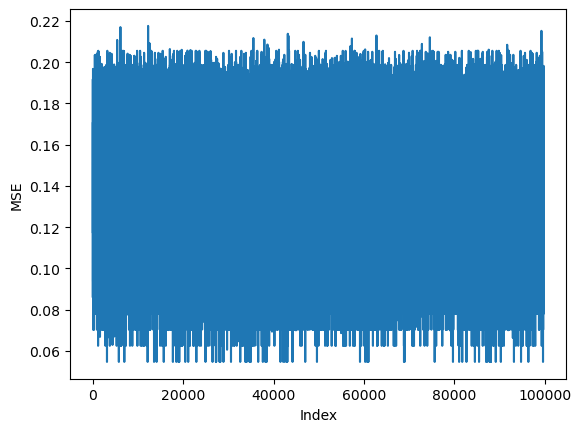

In [11]:
plt.plot(mses)
plt.xlabel('Index')
plt.ylabel('MSE')
plt.show()

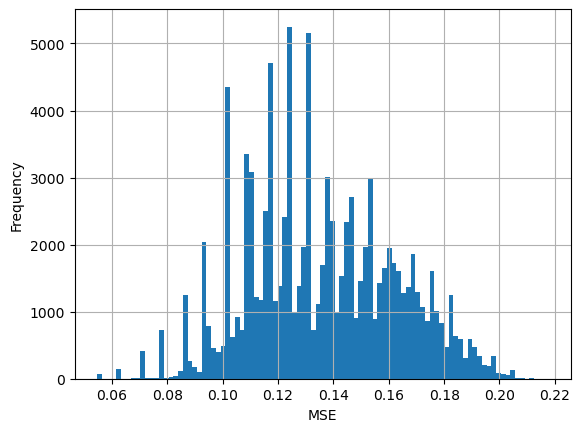

In [12]:
plt.hist(mses, bins = 'auto')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()